### Sentiment Analyis
LSTM, Bidirectional, Pre-trained GloVe embeddings.

IMDb dataset with 50k positive/negative reviews.

In [25]:
import numpy as np
import pandas as pd

# this notebook was originally written in kaggle due to computational resources
# if you wanna' runnit change the data paths
reviews = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [26]:
import re

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [w for w in words if len(w) > 1]
    return words

reviews['preprocessed_review'] = reviews['review'].apply(preprocess)
reviews.head()

,review,sentiment,preprocessed_review
0,One of the other reviewers has mentioned that ...,positive,"[one, of, the, other, reviewers, has, mentione..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, br, br, the, f..."
2,I thought this was a wonderful way to spend ti...,positive,"[thought, this, was, wonderful, way, to, spend..."
3,Basically there's a family where a little boy ...,negative,"[basically, theres, family, where, little, boy..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, matteis, love, in, the, time, of, mon..."


In [27]:
words = set()
for review in reviews['review'].apply(preprocess):
    words.update(review)
words = list(words)
vocab_size = len(words) + 1

vocab_size

175866

In [36]:
word2vec = {}
with open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word2vec[word] = coefs

embed_dim = 100
embed_glove = np.zeros((vocab_size, embed_dim))
for i, word in enumerate(words):
    if word in word2vec:
        embed_glove[i] = word2vec[word]

embed_glove.shape

(175866, 100)

In [29]:
reviews['preprocessed_review'].apply(len).describe()

count    50000.000000
mean       219.384360
std        164.033914
min          4.000000
25%        119.000000
50%        164.000000
75%        266.000000
max       2370.000000
Name: preprocessed_review, dtype: float64

In [37]:
max_len = 200

X = np.zeros((len(reviews), max_len, embed_dim))
for i, review in enumerate(reviews['preprocessed_review']):
    for j, word in enumerate(review):
        if j == max_len:
            break
        if word in word2vec:
            X[i, j] = word2vec[word]

X.shape

(50000, 200, 100)

In [38]:
y = (reviews['sentiment'].values == 'positive').astype(int)

train_size = int(len(reviews)*.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape, X_test.shape)
print(X_train[0][:2])
print(y[0])

(45000, 200, 100) (5000, 200, 100)
[[-0.22556999  0.49417999  0.48609999 -0.4332      0.13738     0.50616997
   0.26058     0.30103001 -0.091486    0.10876     0.30579999  0.051028
   0.22303     0.054236    0.068838   -0.24700999  0.32688999 -0.082203
  -0.28865999  0.3734      0.73803997 -0.040969    0.040201    0.11384
   0.69986999 -0.49744999 -0.06755    -0.42598999 -0.10725    -0.010697
  -0.01479     0.55975997  0.3064      0.053053    0.058034    0.32756001
  -0.37233001  0.46513     0.14285    -0.085003   -0.45475999  0.19773
   0.6383     -0.31147999  0.10858     0.31557     0.36682001 -0.35135001
  -0.48414001 -0.33234999 -0.33816001 -0.39678001  0.1908      1.3513
  -0.39043999 -2.87949991 -0.14275999 -0.087754    1.77129996  0.99331999
  -0.14128999  0.94388998  0.050897    0.47373     0.86387002 -0.16162001
   0.67198998  0.52344     0.14438    -0.055194   -0.34669    -0.20742001
   0.18907    -0.19845     0.34862     0.10121    -0.092119   -0.66258001
  -1.0582     -0.11

In [41]:
import tensorflow as tf
from keras.layers import LSTM, Dense, Input, Dropout, Bidirectional

embeddings = Input(shape=(max_len, embed_dim))
lstm = Bidirectional(LSTM(units=128, return_sequences=True))(embeddings)
dropout = Dropout(.2)(lstm)
lstm = Bidirectional(LSTM(units=128))(dropout)
output = Dense(units=1, activation='sigmoid')(lstm)

model = tf.keras.Model(inputs=embeddings, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 200, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 628,993 (2.40 MB)

 Trainable params: 628,993 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 72s 49ms/step - accuracy: 0.6659 - loss: 0.5985 - val_accuracy: 0.8242 - val_loss: 0.3932
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 67s 48ms/step - accuracy: 0.8341 - loss: 0.3824 - val_accuracy: 0.8386 - val_loss: 0.3602
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 67s 47ms/step - accuracy: 0.8563 - loss: 0.3307 - val_accuracy: 0.8558 - val_loss: 0.3169
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 66s 47ms/step - accuracy: 0.8747 - loss: 0.2931 - val_accuracy: 0.8666 - val_loss: 0.3042
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 67s 47ms/step - accuracy: 0.8895 - loss: 0.2602 - val_accuracy: 0.8572 - val_loss: 0.3378


In [56]:
custom_reviews = ["I didn't like the movie!", "The movie was amazing!"]

for review in custom_reviews:
    r = preprocess(review)
    r = [w for w in r if w in word2vec]
    r = [word2vec[word] for word in r]
    r = np.array(r)
    r = np.expand_dims(r, axis=0)
    r = np.pad(r, ((0, 0), (0, max_len - r.shape[1]), (0, 0)))

    prediction = model.predict(r)
    certainty = np.abs(prediction[0][0] - .5) * 2
    print(review, 'positive' if prediction > .5 else 'negative', round(certainty, 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
I didn't like the movie! negative 0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
The movie was amazing! positive 0.81


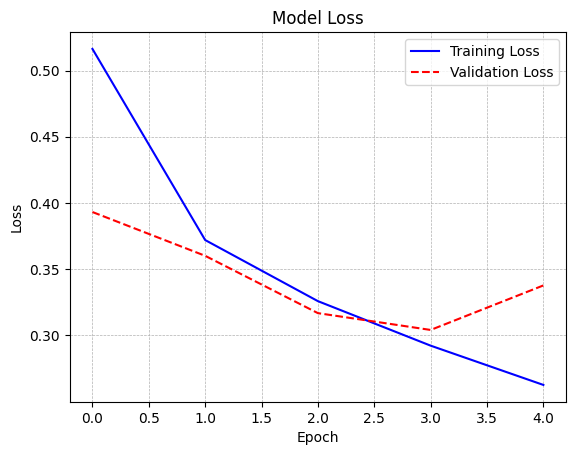

In [60]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color='blue', linestyle='-', label='Training Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()